# Results Deliverable 2

This notebook shows the results of the best models obtained using different techniques. 

It provides the evaluation metrics for the train and test sets and also the results required for the TEST\_SENTENCES.

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline

import matplotlib
import numpy as np
import re
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from Spelling_Correction_c  import Spelling_Correction_c
import seaborn as sns
from matplotlib import cm

import skseq
from skseq.sequences import sequence
from skseq.sequences.sequence import Sequence
from skseq.sequences.sequence_list import SequenceList
from skseq.sequences.label_dictionary import LabelDictionary
import skseq.sequences.structured_perceptron as spc
from skseq.sequences import extended_feature
import time

## Loading the data

We load cleaned datasets containing the training and test data.

In [3]:
data_train = pd.read_csv("clean_train.csv")
data_test = pd.read_csv("clean_test.csv")

We build the X and Y data for both the training and tests sets.

In [4]:
%%time 
X_train = []
Y_train = []

curr_sent = 'Sentence: 1'
list_sent = []
list_y = []
for i in range(data_train.shape[0]):
    #print("current {}/{}".format(i,data_train.shape[0]), end="\r")
    if data_train["Sentence #"][i] == curr_sent:
        list_sent.append(data_train['Word'][i])
        list_y.append(data_train['Tag'][i])
    else:
        curr_sent = data_train["Sentence #"][i]
        X_train.append(list_sent)
        Y_train.append(list_y)
        list_sent = [data_train['Word'][i]]
        list_y = [data_train['Tag'][i]]
        
X_test = []
Y_test = []

curr_sent = 'Sentence: 35970'
list_sent = []
list_y = []
for i in range(data_test.shape[0]):
    #print("current {}/{}".format(i,data_test.shape[0]), end="\r")
    if data_test["Sentence #"][i] == curr_sent:
        list_sent.append(data_test['Word'][i])
        list_y.append(data_test['Tag'][i])
    else:
        curr_sent = data_test["Sentence #"][i]
        X_test.append(list_sent)
        Y_test.append(list_y)
        list_sent = [data_test['Word'][i]]
        list_y = [data_test['Tag'][i]]
        


Wall time: 38.3 s


### Auxiliar functions

In [5]:
def build_word_to_pos(X):

    word_to_pos = {}
    i = 0
    for s in X:
        for w in s:
            if w not in word_to_pos:
                word_to_pos[w] = i
                i +=1
                
    pos_to_word = {v: k for k, v in word_to_pos.items()}
    return word_to_pos, pos_to_word
            
def build_tag_to_pos(Y):
    tag_to_pos = {}
    i = 0
    for s in Y:
        for t in s:
            if t not in tag_to_pos:
                tag_to_pos[t] = i
                i +=1
    pos_to_tag = {v: k for k, v in tag_to_pos.items()}

    return tag_to_pos, pos_to_tag



word_to_pos, pos_to_word = build_word_to_pos(X_train)
tag_to_pos, pos_to_tag  = build_tag_to_pos(Y_train)

def generate_sequence_list(X, y, word_to_pos, tag_to_pos):
    # Generate x and y dicts
    x_dict = LabelDictionary(word_to_pos.keys())
    y_dict = LabelDictionary(tag_to_pos.keys())
    # Generate SequenceList
    seq_list = SequenceList(x_dict, y_dict)
    # Add words/tags to sequencelist
    for i in range(len(X)):
        seq_list.add_sequence(X[i], y[i], x_dict, y_dict)
    return seq_list

train_seq = generate_sequence_list(X_train, Y_train, word_to_pos, tag_to_pos)


## Code to evaluate the metrics

We are going to evaluate the results according to the following metrics:

+ Accuracy on the train set and test set.

+ Confusion matrix on the train and test set.

+ Number of sentences without any label error in both train and test sets (for each sequence you score a 1 if all the words have the correct label and a zero otherwise).

+ The sentences from TEST_SENTENCES (look below) need to be used to evaluate yourwork (besides the accuracy, confusion matrix and number of sentences without any label error).

Here we include the code for the three models.

### Code for Perceptron

In [6]:
def accuracy_corpus(sequences, sequences_predictions):
    """Evaluate classification accuracy at corpus level, comparing with
    gold standard."""
    total = 0.0
    correct = 0.0
    for i, sequence in enumerate(sequences):
        pred = sequences_predictions[i]
        for j, y_hat in enumerate(pred.y):
            if sequence.y[j] == y_hat:
                correct += 1
            total += 1
    return correct / total


def accuracy_predictions(y_seq, sequences_predictions):
    """Evaluate classification accuracy at corpus level, comparing with
    gold standard."""
    total = 0.0
    correct = 0.0
    for i, ys in enumerate(y_seq):
        pred = sequences_predictions[i]
        for j, y_hat in enumerate(pred.y):
            if tag_to_pos[ys[j]] == y_hat:
                correct += 1
            total += 1
    return correct / total

In [7]:
tags = list(tag_to_pos.keys())

def confusion_matrix_corpus(sequences, sequences_predictions):
    """Evaluate classification accuracy at corpus level, comparing with
    gold standard."""
    confusion = np.zeros((len(tags), len(tags)))
    for i, sequence in enumerate(sequences):
        pred = sequences_predictions[i]
        for j, y_hat in enumerate(pred.y):
            if sequence.y[j] == y_hat:
                confusion[y_hat, y_hat] +=1
            else:
                confusion[sequence.y[j], y_hat] +=1
            
    return confusion


def confusion_matrix_predictions(y_seq, sequences_predictions):
    """Evaluate classification accuracy at corpus level, comparing with
    gold standard."""
    total = 0.0
    confusion = np.zeros((len(tags), len(tags)))
    for i, ys in enumerate(y_seq):
        pred = sequences_predictions[i]
        for j, y_hat in enumerate(pred.y):
            if tag_to_pos[ys[j]] == y_hat:
                confusion[y_hat, y_hat] +=1
            else:
                confusion[tag_to_pos[ys[j]], y_hat] +=1      
    return confusion

In [8]:
def sentences_no_errors_corpus(sequences, sequences_predictions):
    """Evaluate classification accuracy at corpus level, comparing with
    gold standard."""
    num_correct = 0
    for i, sequence in enumerate(sequences):
        pred = sequences_predictions[i]
        n = len(pred.y)
        count = 0
        for j, y_hat in enumerate(pred.y):
            if sequence.y[j] == y_hat:
                count +=1
        if count == n:
            num_correct+=1
            
    return num_correct


def sentences_no_errors_predictions(y_seq, sequences_predictions):
    """Evaluate classification accuracy at corpus level, comparing with
    gold standard."""
    num_correct = 0
    for i, ys in enumerate(y_seq):
        pred = sequences_predictions[i]
        n = len(pred.y)
        count = 0
        for j, y_hat in enumerate(pred.y):
            if tag_to_pos[ys[j]] == y_hat:
                count+=1
        if count==n:
            num_correct+=1
        
    return num_correct

In [9]:
def get_prediction_results():
    pred_test = []
    for i in range(len(X_test)):
        p = X_test[i]
        new_seq = skseq.sequences.sequence.Sequence(x=p, y=[int(0) for w in p])
        res = sp.viterbi_decode(new_seq)[0]
        pred_test.append(res)

    pred_train = sp.viterbi_decode_corpus(train_seq)
    
    return pred_test, pred_train
    
def get_prediction_acc(pred_train, pred_test):
    eval_train = accuracy_corpus(train_seq.seq_list, pred_train)
    eval_test = accuracy_predictions(Y_test, pred_test)
    return eval_train, eval_test

def show_confussion_images():
    eval_train = confusion_matrix_corpus(train_seq.seq_list, pred_train)
    eval_test = confusion_matrix_predictions(Y_test, pred_test)

    eval_train = pd.DataFrame(eval_train, columns =tags, index = tags)
    eval_test = pd.DataFrame(eval_test, columns =tags, index = tags)
    
    sns.heatmap(np.log(eval_train+1))
    plt.show()

    sns.heatmap(np.log(eval_test+1))
    plt.show()
    
    return eval_train, eval_test

In [10]:
sentences_test = [
    "The programmers from Barcelona might write a sentence without a spell checker.",
    "The programmers from Barchelona might write a sentence without a spell checker.",
    "Jack London went to Parris.",
    "Jack London went to Paris.",
    "We never though Microsoft would become such a big company.",
    "We never though Microsof would become such a big company.",
    "The president of U.S.A. though they would win the war",
    "The president of the United States of America though they could win the war",
    "The king of Saudi Arabia wanted total control.",
    "Robin does not want to go to Saudi Arabia.",
    "Apple is a great company.",
    "I really love apples and oranges."
]

sentences_seq_test = []
for p in sentences_test:
    sentences_seq_test.append(skseq.sequences.sequence.Sequence(x=p.split(), y=[int(0) for w in p.split()]))

### Code for HMM

In [10]:
def accuracy_HMM(X, Y):
    Y_hat = []
    Y_new = []

    i=0
    for x in tqdm(X):
        try:
            Y_hat.append(hmm.predict_labels(x))
            Y_new.append(Y[i])
        except:
            print("Error: ", i)
        i+=1

    correct = 0
    total   = 0
    for y,y_hat in zip(Y_new,Y_hat):
        for y_hat_k, y_k in zip(y,y_hat):
            total +=1
            if y_hat_k == y_k:
                correct +=1

    return correct/total, Y_hat

In [11]:
def confusion_matrix_HMM(Y_true, Y_hat):
    confusion = np.zeros((len(tags), len(tags)))
    for i, sequence in enumerate(Y_true):
        pred = Y_hat[i]
        for j, y_hat in enumerate(pred):
            y_hat_pos = tag_to_pos[y_hat]
            if sequence[j] == y_hat:
                confusion[y_hat_pos, y_hat_pos] +=1
            else:
                confusion[tag_to_pos[sequence[j]], y_hat_pos] +=1

    return confusion

def show_confussion_images_HMM():
    eval_train = confusion_matrix_HMM(Y_train, Y_hat_train)
    eval_test = confusion_matrix_HMM(Y_test, Y_hat_test)

    eval_train = pd.DataFrame(eval_train, columns =tags, index = tags)
    eval_test = pd.DataFrame(eval_test, columns =tags, index = tags)
 
    sns.heatmap(np.log(eval_train+1))
    plt.show()
    
    sns.heatmap(np.log(eval_test+1))
    plt.show()
    
    return eval_train, eval_test

In [12]:
def sentences_no_errors_HMM(Y_true, Y_hat):
    """Evaluate classification accuracy at corpus level, comparing with
    gold standard."""
    num_correct = 0
    for i, sequence in enumerate(Y_true):
        pred = Y_hat[i]
        n = len(pred)
        count = 0
        for j, y_hat in enumerate(pred):
            if sequence[j] == y_hat:
                count +=1
        if count == n:
            num_correct+=1
            
    return num_correct

In [13]:
import nltk

test_sentences = [ nltk.word_tokenize(sent) for sent in sentences_test]

## Model 1: Structured perceptron

The first type of model we designed to solve the name entity task is a linear discriminative sequence model built using a structured perceptron. 

Discriminative sequence models aim to solve the following:

$$\underset{y\,\in\,\Lambda^N}{\textrm{arg max}}\ P(Y=y\,|\,X=x)=\underset{y\,\in\,\Lambda^N}{\textrm{arg max}}\ \boldsymbol{w}\cdot\boldsymbol{f}(x, y)$$

where $\boldsymbol{w}$ is the model's weight vector, and $\boldsymbol{f}(x, y)$ is a feature vector.

In order to select the best features  $\boldsymbol{f}(x, y)$, we performed model selection in the notebook `ComparisonFeatures.ipnb` in a validation set. The features that we considered were the following:

+ **Closest word**: This feature aims to solve the spelling mistake issue. Given a word `w`, it finds the closest word `w\_sim` belonging to an existing dictionary. If the `w` already belongs to the vocabulary, `w\_sim = w`. The feature has the form `closestWord:w\_sim::dist` where `dist`=distance(`w`, `w\_sim`). 

+ **Suffix**: Checks if the word has a suffix from this list: `['an', 'ian', 'ine', 'ite', 'er', 'eno', 'ish', 'ese', 'i', 'ic', 'iote']`. This feature aims to detect demonyms. The feature has the form `suffix:suffix_name::tag`.

+ **Capitalized**: Whether the word is capitalized or not. The feature has the form `capitalized:tag`.

+ **Uppercase**: Whether all the letters of the word are uppercase. The feature has the form `uppercase:tag`.

+ **Dot**: Whether the word contains dots. The feature is of the form `Dot:tag`.

+ **Hyphen**: Whether the word contains a hyphen. The feature is of the form `Hyphen:tag`.

+ **Numeric**: Whether the string is all numeric. The feature is of the form `Numeric:num\_digits::tag`, where `num\_digits` is the number of digits of the word.

+ **LettersNumbers**: Whether the word contains letters and numbers. The feature is of the form `LettersNumbers:tag`.

+ **DaysWeek**: Whether the word ends with -day. The feature is of the form `DaysWeek:tag`.


After performing feature selection with these features, we found that the best combination was to select only **Closest word + Suffix**. Here we show the performance of such model.


In [42]:
words = list(word_to_pos.keys())
spelling = Spelling_Correction_c(words, tol = 1)

feature_mapper = skseq.sequences.extended_feature.ExtendedFeatures(train_seq, spelling)
feature_mapper.build_features() #get the features

In [47]:
sp = spc.StructuredPerceptron(word_to_pos, tag_to_pos, feature_mapper)
sp.load_model(dir="trained_models/perceptron_extended_features")

### Accuracy on train and test set



In [48]:
pred_test, pred_train = get_prediction_results()
eval_train, eval_test = get_prediction_acc(pred_train, pred_test)
print("SP -  Accuracy Train: %.4f Test: %.4f"%(eval_train, eval_test))

SP -  Accuracy Train: 0.9612 Test: 0.9523


### Confusion matrix on the train and test set

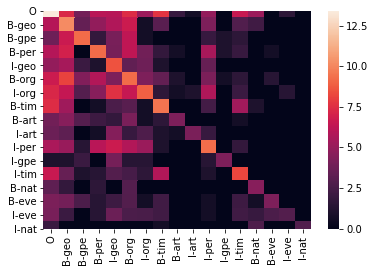

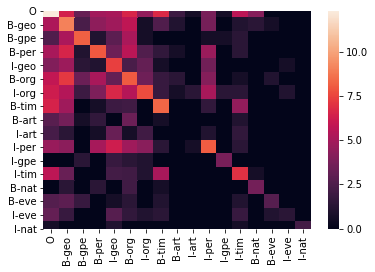

In [49]:
conf_train, conf_test= show_confussion_images()

In [50]:
print("Confusion matrix train")
conf_train

Confusion matrix train


,O,B-geo,B-gpe,B-per,I-geo,B-org,I-org,B-tim,B-art,I-art,I-per,I-gpe,I-tim,B-nat,B-eve,I-eve,I-nat
O,658768.0,1507.0,50.0,466.0,429.0,1724.0,180.0,2230.0,6.0,1.0,140.0,0.0,723.0,177.0,0.0,4.0,0.0
B-geo,407.0,26301.0,31.0,135.0,339.0,842.0,1.0,22.0,0.0,0.0,70.0,0.0,16.0,9.0,0.0,0.0,0.0
B-gpe,44.0,785.0,10343.0,5.0,61.0,541.0,1.0,0.0,0.0,0.0,6.0,2.0,4.0,0.0,0.0,0.0,0.0
B-per,374.0,1073.0,0.0,10381.0,56.0,553.0,48.0,5.0,1.0,0.0,256.0,2.0,6.0,0.0,1.0,0.0,0.0
I-geo,141.0,247.0,7.0,2.0,5078.0,28.0,43.0,2.0,0.0,0.0,33.0,0.0,0.0,0.0,0.0,0.0,0.0
B-org,848.0,3431.0,79.0,353.0,69.0,10112.0,70.0,30.0,2.0,0.0,68.0,1.0,4.0,0.0,3.0,0.0,0.0
I-org,1401.0,654.0,18.0,97.0,1992.0,674.0,7369.0,4.0,1.0,2.0,321.0,0.0,7.0,0.0,0.0,3.0,0.0
B-tim,1691.0,205.0,0.0,1.0,13.0,20.0,1.0,13085.0,0.0,0.0,10.0,0.0,215.0,2.0,0.0,0.0,0.0
B-art,48.0,94.0,18.0,8.0,5.0,63.0,1.0,4.0,70.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
I-art,40.0,26.0,0.0,1.0,85.0,6.0,15.0,2.0,1.0,62.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0


In [51]:
print("Confusion matrix test")
conf_test

Confusion matrix test


,O,B-geo,B-gpe,B-per,I-geo,B-org,I-org,B-tim,B-art,I-art,I-per,I-gpe,I-tim,B-nat,B-eve,I-eve,I-nat
O,218463.0,600.0,25.0,145.0,168.0,725.0,89.0,839.0,6.0,1.0,43.0,1.0,294.0,62.0,0.0,0.0,0.0
B-geo,191.0,8676.0,10.0,81.0,128.0,325.0,1.0,12.0,2.0,0.0,38.0,0.0,2.0,3.0,1.0,0.0,0.0
B-gpe,12.0,186.0,3676.0,2.0,18.0,175.0,1.0,0.0,0.0,0.0,1.0,1.0,3.0,0.0,0.0,0.0,0.0
B-per,167.0,687.0,2.0,2930.0,30.0,282.0,13.0,4.0,1.0,0.0,114.0,0.0,3.0,0.0,0.0,0.0,0.0
I-geo,55.0,119.0,3.0,2.0,1584.0,10.0,23.0,1.0,0.0,0.0,35.0,0.0,0.0,0.0,0.0,1.0,0.0
B-org,357.0,1284.0,29.0,165.0,23.0,3112.0,31.0,5.0,3.0,0.0,60.0,0.0,1.0,0.0,2.0,0.0,0.0
I-org,510.0,228.0,6.0,49.0,789.0,241.0,2232.0,5.0,1.0,3.0,169.0,3.0,3.0,0.0,0.0,2.0,0.0
B-tim,678.0,130.0,0.0,1.0,6.0,7.0,0.0,4173.0,0.0,0.0,4.0,0.0,91.0,0.0,0.0,0.0,0.0
B-art,16.0,37.0,1.0,4.0,0.0,29.0,0.0,1.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0
I-art,9.0,3.0,0.0,1.0,26.0,1.0,7.0,0.0,0.0,0.0,2.0,0.0,4.0,0.0,0.0,0.0,0.0


### Number of sentences without any label error in both train and test sets 

In [52]:
# Evaluate and print number of sentences without error
eval_train = sentences_no_errors_corpus(train_seq.seq_list, pred_train)
eval_test = sentences_no_errors_predictions(Y_test, pred_test)

print("SP - Number of sentences Train: %.0f  Test: %.0f"%(len(pred_train),  len(Y_test)))
print("SP - Number of sentences wihtout error Train: %.0f Test: %.0f"%(eval_train, eval_test))

SP - Number of sentences Train: 35967  Test: 11989
SP - Number of sentences wihtout error Train: 21034 Test: 6279


###  Sentences from TEST_SENTENCES

In [53]:
for new_seq in sentences_seq_test:
    print(sp.viterbi_decode(new_seq)[0].to_words(train_seq,
                                       only_tag_translation=True), '\n')

The/O programmers/O from/O Barcelona/B-geo might/O write/O a/O sentence/O without/O a/O spell/O checker./O  

The/O programmers/O from/O Barchelona/B-geo might/O write/O a/O sentence/O without/O a/O spell/O checker./O  

Jack/B-per London/B-geo went/O to/O Parris./B-geo  

Jack/B-per London/B-geo went/O to/O Paris./B-geo  

We/O never/O though/O Microsoft/B-org would/O become/O such/O a/O big/O company./O  

We/O never/O though/O Microsof/B-geo would/O become/O such/O a/O big/O company./O  

The/O president/O of/O U.S.A./B-geo though/O they/O would/O win/O the/O war/O  

The/O president/O of/O the/O United/B-geo States/I-geo of/I-geo America/I-geo though/O they/O could/O win/O the/O war/O  

The/O king/O of/O Saudi/B-geo Arabia/I-geo wanted/O total/O control./O  

Robin/B-org does/O not/O want/O to/O go/O to/O Saudi/B-per Arabia./I-per  

Apple/B-org is/O a/O great/O company./O  

I/O really/O love/O apples/O and/O oranges./O  



## Model 2: HMM

The second model is an HMM, which we adapted so that it can deal with unseen words. The way to do that is by adding a word "UnknownWord" with small emission probabilities. Then, if a new word arribes (which is not in the word\_to\_pos), it is replaced by "UnknownWord". We fit the model and evaluate the results.

In [54]:
from HMM import HMM

In [55]:
hmm = HMM(word_to_pos, tag_to_pos)

In [56]:
hmm.fit(X_train, Y_train)

/home/laia/Escriptori/Master/NLP/Assignment2/NLP/HMM.py:153: RuntimeWarning: divide by zero encountered in log
  return {"emission":   np.log(probs["emission"]),
/home/laia/Escriptori/Master/NLP/Assignment2/NLP/HMM.py:154: RuntimeWarning: divide by zero encountered in log
  "transition": np.log(probs["transition"]),
/home/laia/Escriptori/Master/NLP/Assignment2/NLP/HMM.py:155: RuntimeWarning: divide by zero encountered in log
  "final":      np.log(probs["final"]),
/home/laia/Escriptori/Master/NLP/Assignment2/NLP/HMM.py:156: RuntimeWarning: divide by zero encountered in log
  "initial":    np.log(probs["initial"])}


### Accuracy on train and test set

In [57]:
acc_train, Y_hat_train = accuracy_HMM(X_train, Y_train)
acc_test, Y_hat_test = accuracy_HMM(X_test, Y_test)

print("HMM-  Accuracy Train: %.4f Test: %.4f"%(acc_train, acc_test))

/home/laia/Escriptori/Master/NLP/Assignment2/NLP/HMM.py:237: RuntimeWarning: invalid value encountered in subtract
  state_posteriors[:, pos] = log_f_x[:, pos] + log_b_x[:, pos] - log_likelihood



HMM-  Accuracy Train: 0.9717 Test: 0.9556


### Confusion matrix on the train and test set

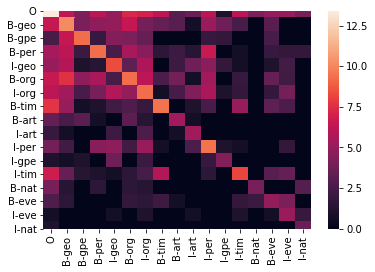

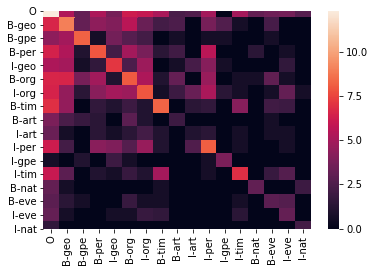

In [58]:
conf_train, conf_test = show_confussion_images_HMM()

In [59]:
print("Confusion matrix train")
conf_train

Confusion matrix train


,O,B-geo,B-gpe,B-per,I-geo,B-org,I-org,B-tim,B-art,I-art,I-per,I-gpe,I-tim,B-nat,B-eve,I-eve,I-nat
O,660595.0,592.0,71.0,509.0,151.0,1391.0,1146.0,522.0,21.0,38.0,461.0,2.0,485.0,72.0,141.0,152.0,56.0
B-geo,674.0,26164.0,63.0,120.0,147.0,662.0,55.0,31.0,20.0,1.0,160.0,43.0,11.0,0.0,22.0,0.0,0.0
B-gpe,12.0,661.0,10902.0,6.0,86.0,69.0,33.0,0.0,0.0,0.0,6.0,5.0,0.0,0.0,12.0,0.0,0.0
B-per,247.0,521.0,7.0,10829.0,12.0,263.0,96.0,4.0,8.0,3.0,749.0,0.0,1.0,0.0,6.0,5.0,5.0
I-geo,168.0,396.0,2.0,3.0,4500.0,27.0,300.0,0.0,8.0,43.0,116.0,5.0,1.0,0.0,2.0,10.0,0.0
B-org,729.0,1990.0,120.0,264.0,12.0,11128.0,501.0,13.0,51.0,1.0,212.0,0.0,6.0,0.0,34.0,9.0,0.0
I-org,521.0,217.0,12.0,56.0,354.0,138.0,10789.0,1.0,12.0,80.0,297.0,2.0,5.0,0.0,5.0,54.0,0.0
B-tim,2237.0,157.0,1.0,2.0,9.0,15.0,6.0,12597.0,0.0,2.0,12.0,0.0,165.0,0.0,26.0,14.0,0.0
B-art,32.0,12.0,23.0,1.0,0.0,24.0,3.0,0.0,216.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
I-art,6.0,1.0,0.0,0.0,8.0,0.0,14.0,0.0,1.0,214.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [60]:
print("Confusion matrix test")
conf_test

Confusion matrix test


,O,B-geo,B-gpe,B-per,I-geo,B-org,I-org,B-tim,B-art,I-art,I-per,I-gpe,I-tim,B-nat,B-eve,I-eve,I-nat
O,219479.0,213.0,23.0,196.0,41.0,504.0,404.0,177.0,10.0,12.0,142.0,0.0,154.0,22.0,32.0,37.0,15.0
B-geo,745.0,8176.0,23.0,81.0,54.0,282.0,27.0,8.0,11.0,0.0,40.0,13.0,1.0,0.0,9.0,0.0,0.0
B-gpe,80.0,140.0,3790.0,1.0,37.0,15.0,8.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0
B-per,648.0,216.0,2.0,2876.0,8.0,142.0,42.0,3.0,7.0,0.0,285.0,0.0,0.0,3.0,0.0,1.0,0.0
I-geo,192.0,148.0,1.0,4.0,1279.0,11.0,121.0,0.0,1.0,9.0,62.0,1.0,0.0,0.0,0.0,4.0,0.0
B-org,739.0,700.0,40.0,134.0,2.0,3116.0,193.0,2.0,23.0,0.0,100.0,0.0,1.0,1.0,20.0,1.0,0.0
I-org,685.0,94.0,3.0,68.0,148.0,116.0,2884.0,1.0,6.0,26.0,181.0,3.0,1.0,0.0,1.0,23.0,1.0
B-tim,1014.0,93.0,0.0,4.0,2.0,6.0,2.0,3882.0,0.0,3.0,4.0,0.0,67.0,0.0,7.0,6.0,0.0
B-art,46.0,10.0,5.0,3.0,0.0,17.0,2.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
I-art,27.0,1.0,0.0,3.0,1.0,3.0,8.0,2.0,0.0,2.0,3.0,0.0,1.0,0.0,1.0,1.0,0.0


### Number of sentences without any label error in both train and test sets

In [61]:
# Evaluate and print number of sentences without error
eval_train = sentences_no_errors_HMM(Y_train, Y_hat_train)
eval_test = sentences_no_errors_HMM(Y_test, Y_hat_test)

print("SP - Number of sentences Train: %.0f Test: %.0f"%(len(Y_train),  len(Y_test)))
print("SP - Number of sentences wihtout error Train: %.0f Test: %.0f"%(eval_train, eval_test))

SP - Number of sentences Train: 35967 Test: 11989
SP - Number of sentences wihtout error Train: 24284 Test: 6817


### Test sentences

In [62]:
for x in test_sentences:
    y = hmm.predict_labels(x)

    result = skseq.sequences.sequence.Sequence(x,y)
    print(result, '\n')

The/O programmers/O from/O Barcelona/B-geo might/O write/O a/O sentence/O without/O a/O spell/O checker/O ./O  

The/O programmers/O from/O Barchelona/O might/O write/O a/O sentence/O without/O a/O spell/O checker/O ./O  

Jack/B-per London/B-geo went/O to/O Parris/O ./O  

Jack/B-per London/B-geo went/O to/O Paris/B-geo ./O  

We/O never/O though/O Microsoft/B-org would/O become/O such/O a/O big/O company/O ./O  

We/O never/O though/O Microsof/O would/O become/O such/O a/O big/O company/O ./O  

The/O president/O of/O U.S.A./O though/O they/O would/O win/O the/O war/O  

The/O president/O of/O the/O United/B-geo States/I-geo of/I-geo America/I-geo though/O they/O could/O win/O the/O war/O  

The/O king/O of/O Saudi/B-geo Arabia/I-geo wanted/O total/O control/O ./O  

Robin/O does/O not/O want/O to/O go/O to/O Saudi/O Arabia/O ./O  

Apple/B-org is/O a/O great/O company/O ./O  

I/O really/O love/O apples/O and/O oranges/O ./O  



# Model 3: BiLSTM

In [13]:
import torch
import torchtext
from torchcrf import CRF

In [60]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

#### Prepare Data for LSTM

In [49]:
# There were some weird artifacts from these characters...
for i in range(len(X_train)):
    for word in X_train[i]:
        
        if word == '\x85':
            idx = X_train[i].index(word) 
            X_train[i].remove(word)
            Y_train[i].pop(idx)

        if word == '\x94':
            idx = X_train[i].index(word) 
            X_train[i].remove(word)
            Y_train[i].pop(idx) 

In [50]:
full_sequence = torchtext.data.Field()
label = torchtext.data.Field(is_target=True)

full_fields = [('sequence', full_sequence), ('tag', label)] 

In [51]:
class CustomDataSet(torchtext.data.Dataset):
    
    def __init__(self, X, y, fields, is_test = False, **kwargs):
        examples = []
        for i in range(len(X)):
            label = y[i] if not is_test else None
            text = X[i]
            examples.append(torchtext.data.Example.fromlist([text,label], fields))
        
        super().__init__(examples, fields, **kwargs)
    
    @staticmethod
    def sortkeys(ex):
        return len(ex.sequence)
    
    @classmethod
    def splits(cls, fields, X_train, y_train, X_val = None, y_val = None, X_test = None, y_test = None, **kwargs):
        train_data, val_data, test_data = (None, None, None)
        
        if X_train is not None:
            train_data = cls(X_train.copy(), y_train.copy(), fields, **kwargs)
        if X_val is not None:
            val_data = cls(X_val.copy(), y_val.copy(), fields, **kwargs)
        if X_test is not None:
            if y_test is not None:
                test_data = cls(X_test.copy(), y_test.copy(), fields, **kwargs)
            else:
                test_data = cls(X_test.copy(), None, fields, True, **kwargs)
                
        return tuple(d for d in (train_data, val_data, test_data) if d is not None)

In [52]:
full_train_ds, full_test_ds = CustomDataSet.splits(full_fields, X_train, Y_train, X_val = None, y_val = None, X_test = X_test, y_test=Y_test)

In [53]:
MAX_VOCAB_SIZE = 35000
full_sequence.build_vocab(full_train_ds, max_size = MAX_VOCAB_SIZE)
label.build_vocab(full_train_ds)

In [54]:
spelling = Spelling_Correction_c(list(full_sequence.vocab.stoi.keys()), tol = 1)

test_sentences_raw = ['The programmers from Barcelona might write a sentence without a spell checker.',
                 'The programmers from Barchelona cannot write a sentence without a spell checker.',
                 'Jack London went to Parris.', 
                 'Jack London went to Paris.',
                 'We never though Microsoft would become such a big company.',
                 'We never though Microsof would become such a big company.',
                 'The president of U.S.A though they could win the war',
                 'The president of the United States of America though they could win the war',
                 'The king of Saudi Arabia wanted total control.',
                 'Robin does not want to go to Saudi Arabia.',
                 'Apple is a great company.',
                 'I really love apples and oranges.']

test_sentences_raw = spelling.correct_text(test_sentences_raw)

import nltk

test_sentences = [ nltk.word_tokenize(sent) for sent in test_sentences_raw]

In [55]:
def load_torch_model(model, path):
    model.load_state_dict(torch.load(path))
    model.to(device)

In [56]:
def make_train_test_iterator(BATCH_SIZE=256, shuffle_train = True):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    train_iterator = torchtext.data.BucketIterator(
        full_train_ds,
        batch_size = BATCH_SIZE,
        shuffle=shuffle_train,
        device=device)

    test_iterator = torchtext.data.BucketIterator(
        full_test_ds,
        shuffle=False,
        batch_size = 1,
        device=device)
    
    return train_iterator, test_iterator

#### Load the model

In [57]:
#model
class RNN(torch.nn.Module):
    def __init__(self, vocab_dim, text, hidden_dim=256, output_dim=len(label.vocab), dropout=0.3, embedding_dim=256, bidirectional=True, num_layers=2):
        super().__init__()
        self.vocab = text.vocab
        self.embedding = torch.nn.Embedding(vocab_dim, embedding_dim)
        self.rnn = torch.nn.LSTM(input_size=embedding_dim, hidden_size=hidden_dim, num_layers=num_layers, dropout=dropout, bidirectional=bidirectional)
        self.fc = torch.nn.Linear(hidden_dim*2 if bidirectional else hidden_dim, output_dim)
        self.act = torch.nn.LeakyReLU(negative_slope=0.01)
        
    def forward(self, sequence):

        #question = [sent len, batch size]        
        embedded = self.embedding(sequence)
    
        #embedded = [sent len, batch size, emb dim]        
        output, hidden = self.rnn(embedded)   
        
        #output = [sent len, batch size, hid dim]  
        L, B, H = output.shape
        output = self.fc(output.view(-1, H)) #B*L, H
        output = output.view(L, B, -1) #L, B, output_dim
        output = self.act(output)
        
        return output

In [61]:
model = RNN(vocab_dim=len(full_sequence.vocab), text=full_sequence)
load_torch_model(model, 'trained_models/LSTM_params_001.txt')

#### Test

In [62]:
train_iterator, test_iterator = make_train_test_iterator(BATCH_SIZE=256, shuffle_train = False)

In [63]:
y_pred_train = []
real_tags_train = []
y_pred_test = []
real_tags_test = []

with torch.no_grad():
    for batch in train_iterator:
        seq, tag = batch.sequence.to(device), batch.tag.to(device)
        output = model(seq)
        y_pred = torch.argmax(output, dim=2)
        
        y_pred_train.append(y_pred.T.tolist())
        real_tags_train.append(tag.T.tolist())
        
    for batch in test_iterator:
        seq, tag = batch.sequence.to(device), batch.tag.to(device)
        output = model(seq) 
        y_pred = torch.argmax(output, dim=2)
        
        y_pred_test.append(y_pred.T.tolist())
        real_tags_test.append(tag.T.tolist())

In [64]:
def flatten_list(l):
    return [item for sublist in l for item in sublist]

In [65]:
y_pred_train = flatten_list(y_pred_train)
y_pred_test = flatten_list(y_pred_test)
real_tags_train = flatten_list(real_tags_train)
real_tags_test = flatten_list(real_tags_test)

In [66]:
def compute_acc(real_tags, pred_tags):
    compare = [np.array([pred_tags[j][i] == tagseq[i] for i in range(len(tagseq))]) for j,tagseq in enumerate(real_tags)]
    all_correct = np.sum([np.all(x) for x in compare])/len(compare)
    acc = np.sum([np.sum(x) for x in compare])/np.sum([x.shape[0] for x in compare])
    
    return acc, all_correct

In [67]:
accuracy_train, n_correct_train = compute_acc(real_tags_train, y_pred_train)
accuracy_test, n_correct_test = compute_acc(real_tags_test, y_pred_test)

In [68]:
print('\t\t|\t Train \t\t|\t Test \t\t|')
print('Accuracy \t|\t %.4f \t|\t %.4f \t|' % (accuracy_train, accuracy_test) )
print('All Correct \t|\t %.4f \t|\t %.4f \t|' % (n_correct_train, n_correct_test) )

		|	 Train 		|	 Test 		|
Accuracy 	|	 0.9953 	|	 0.9615 	|
All Correct 	|	 0.8340 	|	 0.5836 	|


In [69]:
def confusion_matrix(real_tags, pred_tags):
    u_tags = list(label.vocab.stoi.keys())
    u_tags_idx = list(range(len(u_tags)))
    
    cm = np.zeros((len(u_tags), len(u_tags)))
    
    for y, y_pred in zip(real_tags, pred_tags):
        n = len(y)
        for i in range(n):
            cm[y[i], y_pred[i]] += 1
            
    return cm

In [70]:
cm_tr = confusion_matrix(real_tags_train, y_pred_train)
cm_ts = confusion_matrix(real_tags_test, y_pred_test)

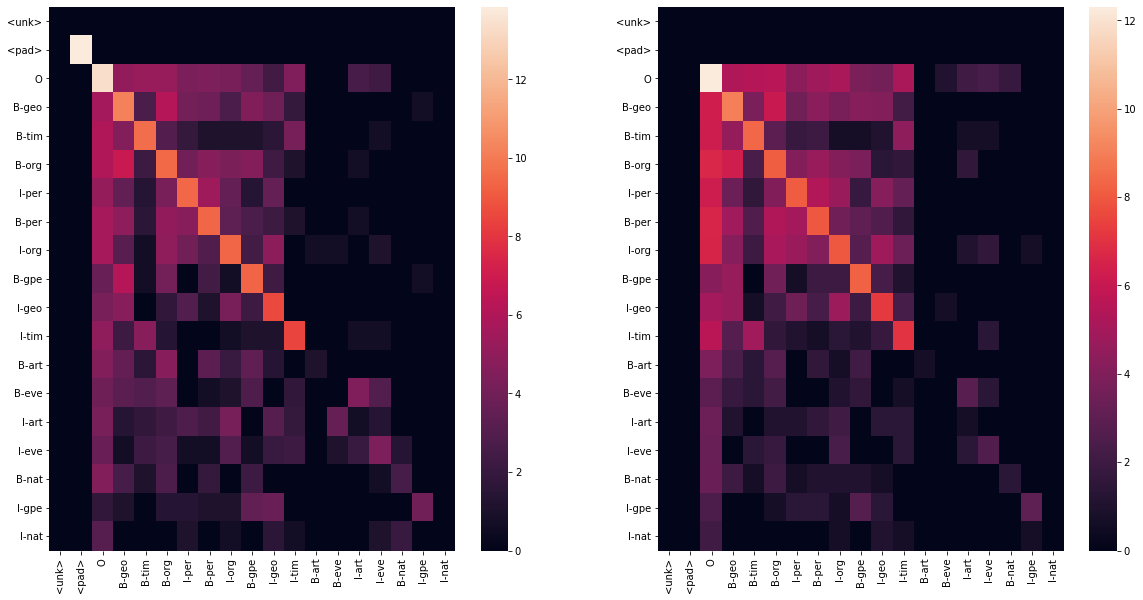

In [71]:
plt.figure(figsize=(20,10))
ax = plt.subplot(121)
sns.heatmap(np.log(cm_tr+1))
ax.set_xticklabels(list(label.vocab.stoi.keys()), rotation='vertical')
ax.set_yticklabels(list(label.vocab.stoi.keys()), rotation='horizontal')
ax = plt.subplot(122)
sns.heatmap(np.log(cm_ts+1))
ax.set_xticklabels(list(label.vocab.stoi.keys()), rotation='vertical')
ax.set_yticklabels(list(label.vocab.stoi.keys()), rotation='horizontal')
plt.show()

In [72]:
def predict_sentence(sent, sequence=sequence, label=label, model=model, device=device, true_label=None):
    numerized = [full_sequence.vocab.stoi[x] for x in sent]
    tensor = torch.tensor([numerized], device=device).T
    pred = model(tensor)
    pred_seq = torch.argmax(pred, dim=2).T.tolist()[0]
    pred_lbl = [label.vocab.itos[x] for x in pred_seq]
    
    if true_label is None:
        return(' '.join([x[0] + '/' + x[1] for x in zip(sent, pred_lbl)]))
    else:
        return(' '.join([x[0] + '/' + x[1] + '/' + x[2] for x in zip(sent, pred_lbl, true_label)]))

In [73]:
with torch.no_grad():
    for s in test_sentences:
        print(predict_sentence(s), '\n')

The/O programmers/O from/O Barcelona/B-geo might/O write/O a/O sentence/O without/O a/O spell/O checker/O ./O 

The/O programmers/O from/O Barchelona/O can/O not/O write/O a/O sentence/O without/O a/O spell/O checker/O ./O 

Jack/B-per London/B-geo went/O to/O Parris/O ./O 

Jack/B-per London/B-geo went/O to/O Paris/B-geo ./O 

We/O never/O though/O Microsoft/B-org would/O become/O such/O a/O big/O company/O ./O 

We/O never/O though/O Microsof/O would/O become/O such/O a/O big/O company/O ./O 

The/O president/O of/O U.S.A/O though/O they/O could/O win/O the/O war/O 

The/O president/O of/O the/O United/B-geo States/I-geo of/I-geo America/I-geo though/O they/O could/O win/O the/O war/O 

The/O king/O of/O Saudi/B-geo Arabia/I-geo wanted/O total/O control/O ./O 

Robin/O does/O not/O want/O to/O go/O to/O Saudi/B-geo Arabia/I-geo ./O 

Apple/O is/O a/O great/O company/O ./O 

I/O really/O love/O apples/O and/O oranges/O ./O 



# Model 3.5: BiLSTM with CRF Layer

In [74]:
#model
class RNN_CRF(torch.nn.Module):
    def __init__(self, vocab_dim, text, hidden_dim=256, output_dim=len(label.vocab), dropout=0.5, embedding_dim=256, bidirectional=True, num_layers=2):
        super().__init__()
        self.vocab = text.vocab
        self.embedding = torch.nn.Embedding(vocab_dim, embedding_dim)
        self.rnn = torch.nn.LSTM(input_size=embedding_dim, hidden_size=hidden_dim, num_layers=num_layers, dropout=dropout, bidirectional=bidirectional)
        self.fc = torch.nn.Linear(hidden_dim*2 if bidirectional else hidden_dim, output_dim)
        self.act = torch.nn.LeakyReLU(negative_slope=0.01)
        self.crf = CRF(output_dim)
        
    def forward(self, sequence):

        #question = [sent len, batch size]        
        embedded = self.embedding(sequence)
    
        #embedded = [sent len, batch size, emb dim]        
        output, hidden = self.rnn(embedded)   
        
        #output = [sent len, batch size, hid dim]  
        L, B, H = output.shape
        output = self.fc(output.view(-1, H)) #B*L, H
        output = output.view(L, B, -1) #L, B, output_dim
        output = self.act(output)
        
        #output = torch.tensor(self.crf.decode(output))
        
        return output

In [76]:
model_crf = RNN_CRF(vocab_dim=len(full_sequence.vocab), text=full_sequence)
load_torch_model(model_crf, 'trained_models/LSTM_CRF_params_001.txt')

In [77]:
train_iterator, test_iterator = make_train_test_iterator(BATCH_SIZE=256, shuffle_train = False)

In [78]:
y_pred_train = []
real_tags_train = []
y_pred_test = []
real_tags_test = []

with torch.no_grad():
    for batch in train_iterator:
        seq, tag = batch.sequence.to(device), batch.tag.to(device)
        output = model_crf(seq)
        y_pred = torch.tensor(model_crf.crf.decode(output)).T.to(device)
        
        y_pred_train.append(y_pred.T.tolist())
        real_tags_train.append(tag.T.tolist())
        
    for batch in test_iterator:
        seq, tag = batch.sequence.to(device), batch.tag.to(device)
        output = model_crf(seq) 
        y_pred = torch.tensor(model_crf.crf.decode(output)).T.to(device)
        
        y_pred_test.append(y_pred.T.tolist())
        real_tags_test.append(tag.T.tolist())

In [79]:
y_pred_train = flatten_list(y_pred_train)
y_pred_test = flatten_list(y_pred_test)
real_tags_train = flatten_list(real_tags_train)
real_tags_test = flatten_list(real_tags_test)

In [80]:
accuracy_train, n_correct_train = compute_acc(real_tags_train, y_pred_train)
accuracy_test, n_correct_test = compute_acc(real_tags_test, y_pred_test)

In [81]:
print('\t\t|\t Train \t\t|\t Test \t\t|')
print('Accuracy \t|\t %.4f \t|\t %.4f \t|' % (accuracy_train, accuracy_test) )
print('All Correct \t|\t %.4f \t|\t %.4f \t|' % (n_correct_train, n_correct_test) )

		|	 Train 		|	 Test 		|
Accuracy 	|	 0.9937 	|	 0.9620 	|
All Correct 	|	 0.8018 	|	 0.5995 	|


In [82]:
cm_tr = confusion_matrix(real_tags_train, y_pred_train)
cm_ts = confusion_matrix(real_tags_test, y_pred_test)

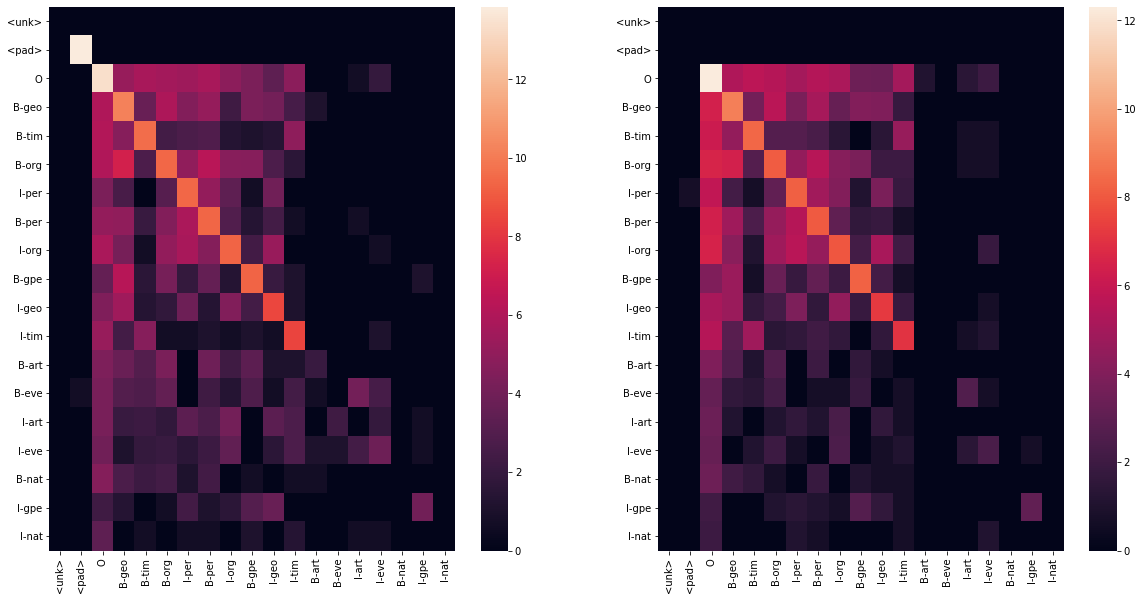

In [83]:
plt.figure(figsize=(20,10))
ax = plt.subplot(121)
sns.heatmap(np.log(cm_tr+1))
ax.set_xticklabels(list(label.vocab.stoi.keys()), rotation='vertical')
ax.set_yticklabels(list(label.vocab.stoi.keys()), rotation='horizontal')
ax = plt.subplot(122)
sns.heatmap(np.log(cm_ts+1))
ax.set_xticklabels(list(label.vocab.stoi.keys()), rotation='vertical')
ax.set_yticklabels(list(label.vocab.stoi.keys()), rotation='horizontal')
plt.show()

In [84]:
def predict_sentence(sent, sequence=sequence, label=label, model=model, device=device, true_label=None):
    numerized = [full_sequence.vocab.stoi[x] for x in sent]
    tensor = torch.tensor([numerized], device=device).T
    pred = model_crf(tensor)
    pred_seq = model_crf.crf.decode(pred)[0]
    pred_lbl = [label.vocab.itos[x] for x in pred_seq]
    
    if true_label==None:
        return(' '.join([x[0] + '/' + x[1] for x in zip(sent, pred_lbl)]))
    else:
        return(' '.join([x[0] + '/' + x[1] + '/' + x[2] for x in zip(sent, pred_lbl, true_label)]))

In [85]:
with torch.no_grad():
    for s in test_sentences:
        print(predict_sentence(s), '\n')

The/O programmers/O from/O Barcelona/B-geo might/O write/O a/O sentence/O without/O a/O spell/O checker/O ./O 

The/O programmers/O from/O Barchelona/O can/O not/O write/O a/O sentence/O without/O a/O spell/O checker/O ./O 

Jack/B-per London/B-geo went/O to/O Parris/O ./O 

Jack/B-per London/B-geo went/O to/O Paris/B-geo ./O 

We/O never/O though/O Microsoft/B-org would/O become/O such/O a/O big/O company/O ./O 

We/O never/O though/O Microsof/O would/O become/O such/O a/O big/O company/O ./O 

The/O president/O of/O U.S.A/B-geo though/O they/O could/O win/O the/O war/O 

The/O president/O of/O the/O United/B-geo States/I-geo of/O America/B-geo though/O they/O could/O win/O the/O war/O 

The/O king/O of/O Saudi/B-org Arabia/I-org wanted/O total/O control/O ./O 

Robin/O does/O not/O want/O to/O go/O to/O Saudi/B-geo Arabia/I-geo ./O 

Apple/B-org is/O a/O great/O company/O ./O 

I/O really/O love/O apples/O and/O oranges/O ./O 

